# Image Pre processing

In [2]:
import os
import hashlib
import cv2
import numpy as np
from PIL import Image

input_dir = "./dataset"
output_dir = "./images"
target_size = 300
os.makedirs(output_dir, exist_ok=True)

hashes = set()
unique_count = 0

def resize_with_padding(image, size=300):
    old_h, old_w = image.shape[:2]
    scale = size / max(old_h, old_w)
    new_w, new_h = int(old_w * scale), int(old_h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    top = (size - new_h) // 2
    bottom = size - new_h - top
    left = (size - new_w) // 2
    right = size - new_w - left
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

for filename in os.listdir(input_dir):
    filepath = os.path.join(input_dir, filename)

    # Check if image is valid
    try:
        with open(filepath, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
    except Exception:
        continue

    if filehash not in hashes:
        hashes.add(filehash)
        img = cv2.imread(filepath)
        if img is not None:
            padded_img = resize_with_padding(img, target_size)
            cv2.imwrite(os.path.join(output_dir, filename), padded_img)
            unique_count += 1

print("Total unique images saved:", unique_count)

Total unique images saved: 8090


In [4]:
import os
import cv2
import numpy as np

input_folder = "./images"
normalized_images = []

for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)

        if image is None:
            continue

        # Convert BGR to RGB (optional, but recommended for ML)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize to [0, 1]
        normalized = image.astype(np.float32) / 255.0

        normalized_images.append(normalized)

normalized_images_array = np.array(normalized_images)

print("Total images loaded:", len(normalized_images_array))
print("Shape of one image:", normalized_images_array[0].shape)

Total images loaded: 8090
Shape of one image: (300, 300, 3)


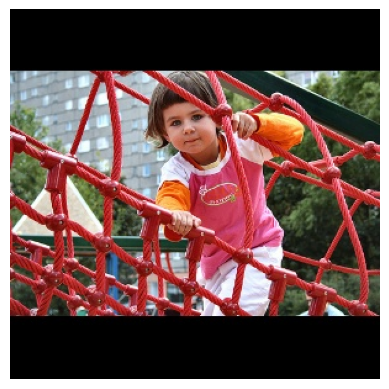

In [5]:
import matplotlib.pyplot as plt
plt.imshow(normalized_images_array[5])
plt.axis('off')
plt.show()

In [6]:
print(normalized_images_array[0][0])

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.  

# Caption Preprocessing.

In [9]:
import re
import csv
import json,pickle
import string
from collections import defaultdict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

def load_clean_captions(filename):
    captions_dict = defaultdict(list)

    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # skip header

        for row in reader:
            if len(row) != 2:
                continue  # skip bad lines

            image, caption = row
            image = image.split('.')[0]
            if len(captions_dict[image]) < 2:
                captions_dict[image].append(caption.strip())

    return dict(captions_dict)


def preprocess_captions(captions_dict):
    table = str.maketrans('', '', string.punctuation)
    cleaned_captions = {}

    for img, caps in captions_dict.items():
        cleaned_set = set()
        cleaned_captions[img] = []
        for caption in (caps):
            caption = caption.lower().translate(table)  # lowercase + remove punctuation

            # Remove emojis and non-ASCII characters
            caption = re.sub(r'[^\x00-\x7F]+', '', caption)

            # Remove extra spaces
            caption = re.sub(r'\s+', ' ', caption).strip()
            caption = f"<start> {caption} <end>"
            cleaned_set.add(str(caption))
        cleaned_captions[img] = list(cleaned_set)

    return cleaned_captions

captions_dict = load_clean_captions("./captions.txt")
cleaned = preprocess_captions(captions_dict)
for img, caps in list(cleaned.items())[:2]:
    print(f"{img}:")
    for cap in caps:
        print(f"  - {(cap)}")


1000268201_693b08cb0e:
  - <start> a child in a pink dress is climbing up a set of stairs in an entry way <end>
  - <start> a girl going into a wooden building <end>
1001773457_577c3a7d70:
  - <start> a black dog and a spotted dog are fighting <end>
  - <start> a black dog and a tricolored dog playing with each other on the road <end>


In [10]:
# Save cleaned captions to a JSON file
with open("./cleaned_captions.json", "w", encoding="utf-8") as f:
    json.dump(cleaned, f, ensure_ascii=False, indent=2)

In [11]:
all_captions = []
for caps in cleaned.values():
    all_captions.extend(caps)
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

with open("./tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save vocab size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print("Vocabulary Size:", vocab_size)

with open("./tokenizer_vocab.json", "w", encoding="utf-8") as f:
    json.dump(tokenizer.word_index, f, ensure_ascii=False, indent=4)


Vocabulary Size: 6065


In [14]:
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(all_captions))
max_length

35

In [15]:
for img, caps in list(cleaned.items())[:2]:
    print(f"{img}:")
    for cap in caps:
        print(f"  - {cap}")

1000268201_693b08cb0e:
  - <start> a child in a pink dress is climbing up a set of stairs in an entry way <end>
  - <start> a girl going into a wooden building <end>
1001773457_577c3a7d70:
  - <start> a black dog and a spotted dog are fighting <end>
  - <start> a black dog and a tricolored dog playing with each other on the road <end>


In [16]:
tokenized_captions = {}
for img, caps in cleaned.items():
    seqs = tokenizer.texts_to_sequences(caps)
    tokenized_captions[img] = pad_sequences(seqs, maxlen=max_length, padding='post')


In [17]:
import numpy as np
# Flatten to save
np.savez("./tokenized_captions.npz", **{
    img: np.array(seqs) for img, seqs in tokenized_captions.items()
})


In [18]:
for img, caps in list(tokenized_captions.items())[:2]:
    print(f"{img}:")
    for cap in caps:
        print(f"  - {cap[:14]}")

1000268201_693b08cb0e:
  - [  4   2  40   5   2  80 157   9 119  51   2 427  12 394]
  - [  4   2  17 294  62   2 211 124   3   0   0   0   0   0]
1001773457_577c3a7d70:
  - [  4   2  14  10   8   2 775  10  19 372   3   0   0   0]
  - [   4    2   14   10    8    2 1820   10   36   13  160   92    7    6]


In [20]:
# tokenizer.word_counts is an OrderedDict: word → count
word_frequencies = dict(tokenizer.word_counts)

# Save to JSON
with open("./word_frequencies.json", "w", encoding="utf-8") as f:
    json.dump(word_frequencies, f, ensure_ascii=False, indent=4)